<a href="https://colab.research.google.com/github/rezamohammadloo/FER_vgg16/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#connecting to google drive to get teh data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
# Import all the necessary files!
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [15]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (75, 75, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary()

--2024-02-08 18:38:34--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c06::cf, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   123MB/s    in 0.7s    

2024-02-08 18:38:35 (123 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 75, 75, 3)]          

In [16]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [17]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (7, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 37, 37, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 37, 37, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 37, 37, 32)           0         ['batch_normalization_94

In [18]:
# Extract the archive
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/archive.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [19]:
#main directories
train_dir = '/content/train'
test_dir  = '/content/test'

In [20]:
#analyzing the data
lable_names = os.listdir(train_dir)
print(f'class labels:{lable_names}')

for i in lable_names:
  print(f'\nnumber of train images in class {i} is: {len(os.listdir(os.path.join(train_dir, i)))}')
  print(f'number of test  images in class {i} is: {len(os.listdir(os.path.join(test_dir, i)))}')

class labels:['neutral', 'surprise', 'fear', 'happy', 'angry', 'disgust', 'sad']

number of train images in class neutral is: 4965
number of test  images in class neutral is: 1233

number of train images in class surprise is: 3171
number of test  images in class surprise is: 831

number of train images in class fear is: 4097
number of test  images in class fear is: 1024

number of train images in class happy is: 7215
number of test  images in class happy is: 1774

number of train images in class angry is: 3995
number of test  images in class angry is: 958

number of train images in class disgust is: 436
number of test  images in class disgust is: 111

number of train images in class sad is: 4830
number of test  images in class sad is: 1247


<Axes: >

<Figure size 1500x1000 with 0 Axes>

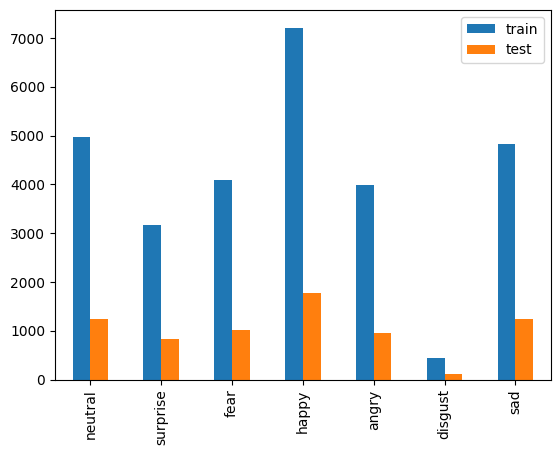

In [21]:
dict = {}
for i in lable_names:
  dict.update(({i:[ len(os.listdir(os.path.join(train_dir, i))) , len(os.listdir(os.path.join(test_dir, i)))]}))

df = pd.DataFrame(dict).T
df.columns = ['train', 'test']

plt.figure(figsize = (15,10))
df.plot(kind = 'bar' )

In [22]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen  = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(75, 75),  # All images will be resized to 48x48
        batch_size=256,
        class_mode='categorical')# Since we use categorical_crossentropy loss, we need binary labels


# Flow validation images in batches of 64 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(75, 75),
        batch_size=256,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 112,
            epochs = 10,
            validation_steps = 24,
            verbose = 1)

Epoch 1/10
112/112 [==============================] - 286s 3s/step - loss: 2.3269 - accuracy: 0.3690 - val_loss: 1.4630 - val_accuracy: 0.4294
Epoch 2/10
112/112 [==============================] - 279s 2s/step - loss: 1.4310 - accuracy: 0.4528 - val_loss: 1.3810 - val_accuracy: 0.4657
Epoch 3/10
112/112 [==============================] - 313s 3s/step - loss: 1.3294 - accuracy: 0.4903 - val_loss: 1.3742 - val_accuracy: 0.4808
Epoch 4/10
112/112 [==============================] - 314s 3s/step - loss: 1.2471 - accuracy: 0.5261 - val_loss: 1.3669 - val_accuracy: 0.4868
Epoch 5/10
112/112 [==============================] - 315s 3s/step - loss: 1.1667 - accuracy: 0.5632 - val_loss: 1.2677 - val_accuracy: 0.5223
Epoch 6/10
112/112 [==============================] - 310s 3s/step - loss: 1.0927 - accuracy: 0.5933 - val_loss: 1.2765 - val_accuracy: 0.5220
Epoch 7/10
112/112 [==============================] - 319s 3s/step - loss: 1.0212 - accuracy: 0.6205 - val_loss: 1.3688 - val_accuracy: 0.4998

<ipython-input-24-25fe6731c02a>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


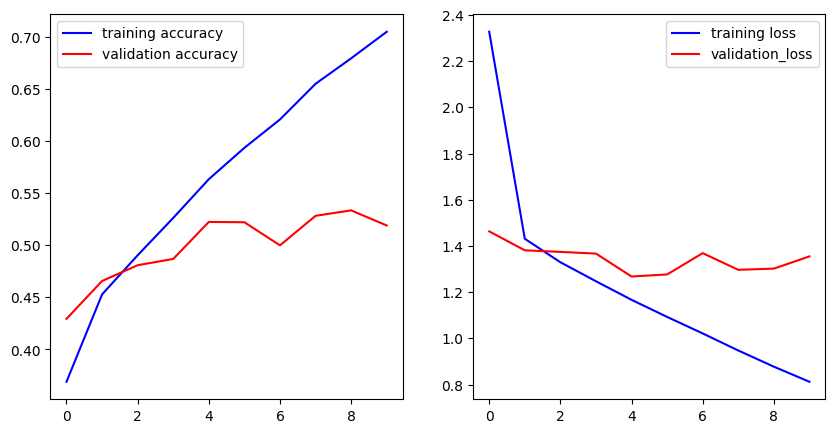

In [24]:
#plotting acc and loss curves to get a beeter understanding of our network's performance
plt.subplots(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='b', label="training accuracy")
plt.plot(history.history['val_accuracy'], color='r', label="validation accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='b', label="training loss")
plt.plot(history.history['val_loss'], color='r', label="validation_loss")
plt.legend()